## Tracking pipeline <br>
This notebook will guide you through steps required to track honeybees, from detection to trajectory construction. The pipeline contains two neural networks, one for object detection and one for building embeddings of visual features of detections that is used in trajectory construction. With this code we provide pretrained networks, that however might not work perfect for your specific imaging data. For this purpose we include in the pipeline __retraining procedures__ that allow to validate and correct the results you obtain and retrain the networks of the corrected data. Such retraining, with only small burden of manual work, should dramatically improve model performance on the specific data you are working on. <BR>
 
With this pipeline we provide sample data that this notebook can be deployed on. To make it work on your data, arrange it in the same way as the provided data, or adjust the data handling code. 

### Requirements
* Python 3.5+
* [TensorFlow](https://www.tensorflow.org/) (1 or higher)
* [Numpy](http://www.numpy.org/)
* [Pillow](https://pillow.readthedocs.io/en/stable/)
* [matplotlib](https://matplotlib.org/)
* [opencv](https://opencv.org/)
* [scikit-learn](https://scikit-learn.org/stable/)


First we will download and unpack sample data for this notebook (depending on your connection this might take a moment):

In [ ]:
import urllib.request, tarfile, os
import utils

fname = "data.tgz"
progress = utils.DownloadProgress()
urllib.request.urlretrieve("https://beepositions.unit.oist.jp/" + fname, fname, reporthook=progress.progress_hook)

with tarfile.open(fname, "r:gz") as tar:
    tar.extractall()

os.remove(fname)

The structure of the data folder is:<br>
```
sample_data
+-- checkpoints  
|   +-- model_005000.ckpt.*
+-- frames  
|   +-- *.png
```
`frames` folder contains following in time frames from a video of a beehive. If you want to use your data extract the following frames of a video recording into this folder and name them with a `"%06d.png` format.<br>
We will now run the detection procedure on these images:

In [ ]:
import detection.find_det as fd

fd.find_detections()

`detection` subfolder of the data folder contains now detections of bees in the respective frames, with text format `x,y,class,angle` for each detection. <br>
We will plot detections to inspect their accuracy. We can plot individual frames:

In [ ]:
from IPython.core.display import Image, display
import plot

fr = 10
plot.plot_detections(fr, save=True)
display(Image(os.path.join(utils.PLOTS_DIR, "%06d.png" % fr), unconfined=True))

Some results migh look imprecise, or there might be false positive detections. To improve these results, use [this tool](https://github.com/oist/DenseObjectAnnotation) to correct the prediction. Download the code, follow installation instructions, then copy the `data/frames/*.png` files to the `DenseObjectAnnotation/static/png` folder of the and `data/detections/*.txt` to `DenseObjectAnnotation/static/txt` folder. To allow to work with images in the provided dataset, change the `ZOOM_LEVEL = 1.0;` parameter in the `static/annotate.js` file. If you are working with images of another size, adjust the zoom level accordingly.<br>
Correct a range of frames in consecutive order, for example frames 0, 1, 2, .. 10. After correcting, create a training set from the corrected frames, the function `create_from_frames` takes as input: the range of corrected frames, location of the annotation results, and location of the corresponging images.

In [ ]:
from detection import dataset

static_dir = "../DenseObjectAnnotation/static"
dataset.create_from_frames(range(10), os.path.join(static_dir, "png"), os.path.join(static_dir, "txt"))

To plot and display sample semgentation maps:

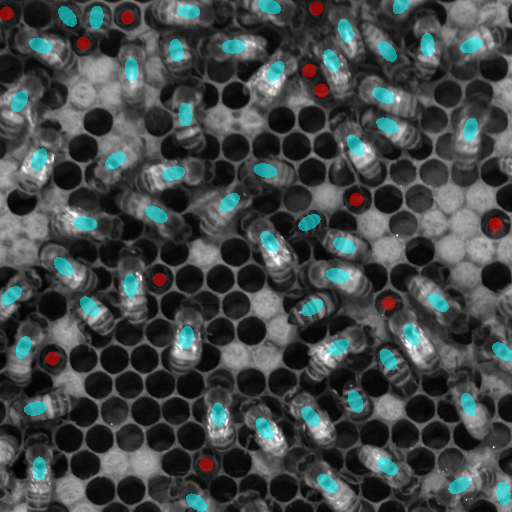

In [2]:
from plots import segm_map

frame_nb = 5

class_map = segm_map.plot_segm_map(frame_nb)
display(class_map)

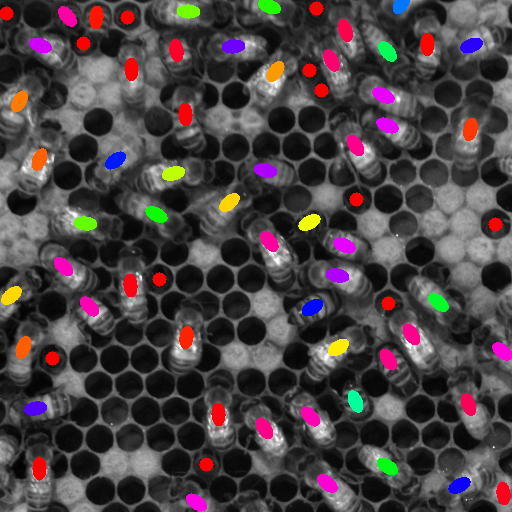

In [3]:
angle_map = segm_map.plot_angle_map(frame_nb)

display(angle_map)

We will now train the detection network on the range of corrected images. The training function uses all `*.npz` files from the data folder given as parameter. A default value is provided matching the default output of the `dataset.create_from_frames` function. Input parameter `train_prop` defines what proportion of the input should be used as training (by default 0.9), remaining frames will be used to estimate test error.<br>
During training the function iterates over the input files and randomly samples window of a size `256x256 pixel` and randomly flips the input along x- and y-axes.
The last existing checkpoint of this network will be read in from the default location in the data subfolder. The function will repeat the training `n_iters` times (by default 10).

There is 100 frames in this sample dataset, we can merge them into an animation. For convenience, here instead of vidoes we will generate animated gif files. The files will be stored in the data folder and displayed here below. The animation is played in a repeated loop.<br>
To generate the animation:

In [ ]:
plot.plot_detection_video()

display(Image(os.path.join(utils.PLOTS_DIR, "detections.gif")))

In the trajectory construction procedure we exploit not only position and postural information that is included in the `detections` folder, but also numeric *embeddings* encoding visual aspects of each individual bee. The embeddings are derived from a pretrained neural network.<br>
You can build the embeddings with the `build_embeddings` function in the `embed` module. This function will read the image and detection data, crop the detections from the images and feed into the network. The output of the network is then saved in text and binary files in the `detections_embeddings` subfolder of the data folder.<br>
To run the procedure:

In [ ]:
import embed
embed.build_embeddings()

In the created files the position and posture information `x,y,class,angle` of each detection is concatenated with another 64 numbers forming the embedding of the detection visual features:

In [ ]:
import numpy as np

fr = 10
det = np.load(os.path.join(utils.FTS_DIR, "%06d.npy" % fr))
print("frame %i - detections: %i, embedding size: %i" % (fr, det.shape[0], det.shape[1]-4))

Using the embeddings we will now perform trajectory construction procedure. The logic and parameters of this procedure are described in our manuscript and included in the `track` module. We will first perform the matching `build_trajectories()`, then sort them according to their length `sort_trajectories`:

In [ ]:
import track

track.build_trajectories()
track.sort_trajectories()

Generated trajectories are located in the `trajectories` subfolder of the data folder. In addition to trajectory files, file `tra_lens.txt` lists starting point and length of each trajectory. Using this file can easily inspect the lengths of the generated trajectories:

In [ ]:
import matplotlib.pyplot as plt

tra_lens = np.loadtxt(os.path.join(utils.TRACK_DIR, "tra_lens.txt"), delimiter=",", dtype=np.int)
_ = plt.hist(tra_lens[:,1], bins=50)
_ = plt.xlabel('Trajectory lengths')

Now we can generate animations of some example trajectories. All files will be stored in the `plots` subfolder of the data folder.

In [ ]:
from IPython.core.display import Image, display
import plot, utils

trajectory = 28 # change this number to plot any other generated trajectory
trajectory_filename = plot.plot_trajectory(trajectory)
display(Image(trajectory_filename))

We can also generate a video of all generated trajectories:

In [ ]:
all_trajectories_filename = plot.plot_all_trajectories()
display(Image(all_trajectories_filename))